In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

---

# Model Training

In [3]:
class FeatureDataset(Dataset):
    def __init__(self, features, labels, lengths):
        self.features = features
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        length = self.lengths[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y), length


In [9]:
def load_data(test_fold, feat_type):
    train_features, train_labels, train_lengths = [], [], []
    test_features, test_labels, test_lengths = None, None, None
    
    for i in range(5):
        data = np.load(f"/kaggle/input/uta-rldd-combined-feature-vectors/{feat_type}/combined_fold_{i+1}.npz", allow_pickle=True)
        if i != test_fold-1:
            train_features.extend(data["features"])
            train_labels.extend(data["labels"])
            train_lengths.extend(data["lengths"])
        else:
            test_features = data["features"]
            test_labels = data["labels"]
            test_lengths = data["lengths"]
    
    scaler = StandardScaler()
    yolo_scaler = StandardScaler()
    flat_train = np.vstack([np.vstack(x) for x in train_features])
    scaler.fit(flat_train[:, :5])
    yolo_scaler.fit(flat_train[:, 5:])
    train_features_feat = np.array([scaler.transform(np.array(x)[:, :5]) for x in train_features], dtype="object")
    train_features_yolo_feat = np.array([yolo_scaler.transform(np.array(x)[:, 5:]) for x in train_features], dtype="object")
    train_features = [np.concatenate((train_features_feat[i], train_features_yolo_feat[i]), axis=1) for i in range(len(train_features_feat))]
    test_features_feat = np.array([scaler.transform(np.array(x)[:, :5]) for x in test_features], dtype="object")
    test_features_yolo_feat = np.array([yolo_scaler.transform(np.array(x)[:, 5:]) for x in test_features], dtype="object")
    test_features = [np.concatenate((test_features_feat[i], test_features_yolo_feat[i]), axis=1) for i in range(len(test_features_feat))]

    return train_features, train_labels, train_lengths, test_features, test_labels, test_lengths

In [10]:
def collate_fn(batch):
    xs, ys, lengths = zip(*batch)
    ys = torch.stack(ys)
    lengths = torch.tensor(lengths)
    xs = pad_sequence(xs, batch_first=True, padding_value=-999)
    return xs, ys, lengths

In [35]:
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers):
        super(GRUClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_dim,
            hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=0.1, 
            bidirectional=True
        )
        
        self.norm = nn.LayerNorm(hidden_dim * 2)

        # Attention layer
        self.attn = nn.Linear(hidden_dim * 2, 1)

        # Fully connected classifier
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )


    def forward(self, x, lengths):
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.gru(packed)
        padded_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        max_len = padded_out.size(1)
        mask = torch.arange(max_len, device=lengths.device).unsqueeze(0) < lengths.unsqueeze(1)
        norm_out = self.norm(padded_out)
        scores = self.attn(torch.tanh(norm_out)).squeeze(-1)
        scores = scores.masked_fill(~mask, float('-1e9'))
        att_w = torch.softmax(scores, dim=1).unsqueeze(-1)
        context = torch.sum(att_w * padded_out, dim=1)
        out = self.fc(context)
        return out

In [12]:
def train_model(model, train_loader, val_loader, device,
                num_epochs=100, patience=5, lr=1e-4,
                checkpoint_path="best_model.pth"):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    best_val_loss = float("inf")
    best_pred = []

    history = []
    
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, total = 0, 0
        y_pred, y_true = [], []
        
        for xs, ys, lengths in tqdm(train_loader, desc=f"Train {epoch+1}/{num_epochs}"):
            xs, ys, lengths = xs.to(device), ys.to(device), lengths.to(device)

            optimizer.zero_grad()
            outputs = model(xs, lengths)
            loss = criterion(outputs, ys)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item() * ys.size(0)
            _, pred = outputs.max(1)
            y_pred.extend(pred.cpu().numpy())
            y_true.extend(ys.cpu().numpy())
            total += ys.size(0)

        train_acc = accuracy_score(y_true, y_pred)
        train_loss /= total

        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xs, ys, lengths in val_loader:
                xs, ys, lengths = xs.to(device), ys.to(device), lengths.to(device)

                outputs = model(xs, lengths)
                loss = criterion(outputs, ys)

                val_loss += loss.item() * ys.size(0)
                
                probs = torch.softmax(outputs, dim=-1)
                pred = torch.argmax(probs, dim=-1)
                total += ys.size(0)

                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(ys.cpu().numpy())

        val_acc = accuracy_score(all_labels, all_preds)
        val_loss /= total
        
        print(f"Epoch {epoch+1}: "
              f"Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_pred = all_preds
            patience_counter = 0
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_loss": val_loss,
            }, checkpoint_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                print("Classification Report: \n", classification_report(all_labels, best_pred, target_names=["Alert", "Low Vigilant", "Drowsy"]))
                ConfusionMatrixDisplay(
                    confusion_matrix=confusion_matrix(all_labels, best_pred),
                    display_labels=["Alert", "Low Vigilant", "Drowsy"]
                ).plot()
                plt.show()
                break

        if epoch == num_epochs-1:
            print("Early stopping triggered")
            print("Classification Report: \n", classification_report(all_labels, best_pred, target_names=["Alert", "Low Vigilant", "Drowsy"]))
            ConfusionMatrixDisplay(
                confusion_matrix=confusion_matrix(all_labels, best_pred),
                display_labels=["Alert", "Low Vigilant", "Drowsy"]
            ).plot()
            plt.show()

## First (fold 5 as test)

In [28]:
train_features, train_labels, train_lengths, test_features, test_labels, test_lengths = load_data(5, "frames")

Train 1/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 1: Train Loss 1.0988, Acc 0.3472 | Val Loss 1.0995, Acc 0.3056


Train 2/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 2: Train Loss 1.0936, Acc 0.3611 | Val Loss 1.0993, Acc 0.3056


Train 3/200: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Epoch 3: Train Loss 1.0908, Acc 0.3681 | Val Loss 1.0993, Acc 0.2778


Train 4/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 4: Train Loss 1.0848, Acc 0.4167 | Val Loss 1.0994, Acc 0.2778


Train 5/200: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Epoch 5: Train Loss 1.0790, Acc 0.4653 | Val Loss 1.0990, Acc 0.2778


Train 6/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 6: Train Loss 1.0734, Acc 0.5208 | Val Loss 1.0986, Acc 0.2778


Train 7/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 7: Train Loss 1.0684, Acc 0.5694 | Val Loss 1.0978, Acc 0.2778


Train 8/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 8: Train Loss 1.0605, Acc 0.6319 | Val Loss 1.0972, Acc 0.3333


Train 9/200: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 9: Train Loss 1.0606, Acc 0.6042 | Val Loss 1.0966, Acc 0.3333


Train 10/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 10: Train Loss 1.0531, Acc 0.6806 | Val Loss 1.0965, Acc 0.3611


Train 11/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 11: Train Loss 1.0438, Acc 0.6736 | Val Loss 1.0969, Acc 0.3889


Train 12/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 12: Train Loss 1.0351, Acc 0.7153 | Val Loss 1.0964, Acc 0.3889


Train 13/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 13: Train Loss 1.0309, Acc 0.7153 | Val Loss 1.0958, Acc 0.3889


Train 14/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 14: Train Loss 1.0196, Acc 0.7431 | Val Loss 1.0952, Acc 0.4167


Train 15/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 15: Train Loss 1.0128, Acc 0.7569 | Val Loss 1.0947, Acc 0.4167


Train 16/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 16: Train Loss 0.9989, Acc 0.7292 | Val Loss 1.0940, Acc 0.4167


Train 17/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 17: Train Loss 0.9867, Acc 0.7639 | Val Loss 1.0940, Acc 0.4444


Train 18/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 18: Train Loss 0.9660, Acc 0.7986 | Val Loss 1.0931, Acc 0.4167


Train 19/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 19: Train Loss 0.9592, Acc 0.7361 | Val Loss 1.0917, Acc 0.4722


Train 20/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 20: Train Loss 0.9368, Acc 0.7708 | Val Loss 1.0919, Acc 0.4167


Train 21/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 21: Train Loss 0.9105, Acc 0.7986 | Val Loss 1.0942, Acc 0.4167


Train 22/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 22: Train Loss 0.8854, Acc 0.7639 | Val Loss 1.0966, Acc 0.4167


Train 23/200: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Epoch 23: Train Loss 0.8648, Acc 0.7778 | Val Loss 1.1006, Acc 0.3889


Train 24/200: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 24: Train Loss 0.8147, Acc 0.7639 | Val Loss 1.1054, Acc 0.3611


Train 25/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 25: Train Loss 0.7978, Acc 0.8056 | Val Loss 1.1123, Acc 0.3611


Train 26/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 26: Train Loss 0.7488, Acc 0.8264 | Val Loss 1.1287, Acc 0.3889


Train 27/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 27: Train Loss 0.7128, Acc 0.8333 | Val Loss 1.1503, Acc 0.3611


Train 28/200: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Epoch 28: Train Loss 0.6694, Acc 0.8403 | Val Loss 1.1656, Acc 0.3611


Train 29/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 29: Train Loss 0.6274, Acc 0.8472 | Val Loss 1.1950, Acc 0.3611
Early stopping triggered
Classification Report: 
               precision    recall  f1-score   support

       Alert       0.44      0.58      0.50        12
Low Vigilant       0.50      0.50      0.50        12
      Drowsy       0.50      0.33      0.40        12

    accuracy                           0.47        36
   macro avg       0.48      0.47      0.47        36
weighted avg       0.48      0.47      0.47        36



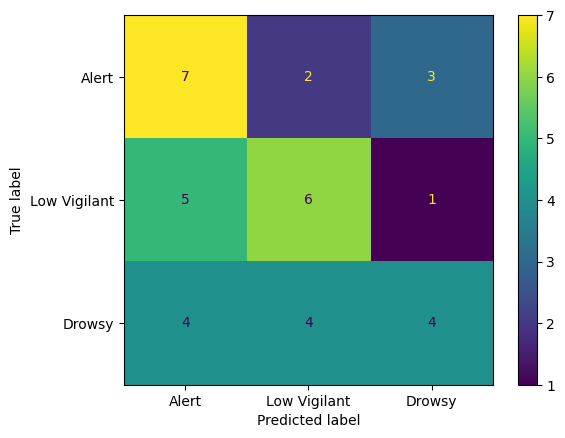

In [36]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

train_dataset = FeatureDataset(train_features, train_labels, train_lengths)
test_dataset = FeatureDataset(test_features, test_labels, test_lengths)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

model = GRUClassifier(input_dim=np.array(train_features[0]).shape[1], hidden_dim=128, num_classes=3, num_layers=2).to(device)
train_model(model, train_loader, test_loader, device,
                num_epochs=200, patience=10,
                checkpoint_path="/kaggle/working/best_model_5_test.pth")

## Second (fold 4 as test)

In [15]:
train_features, train_labels, train_lengths, test_features, test_labels, test_lengths = load_data(4, "frames")

Train 1/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 1: Train Loss 1.1022, Acc 0.3681 | Val Loss 1.0975, Acc 0.3333


Train 2/200: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Epoch 2: Train Loss 1.0918, Acc 0.3194 | Val Loss 1.0950, Acc 0.3056


Train 3/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 3: Train Loss 1.0843, Acc 0.4861 | Val Loss 1.0929, Acc 0.3889


Train 4/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 4: Train Loss 1.0749, Acc 0.4722 | Val Loss 1.0915, Acc 0.4167


Train 5/200: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Epoch 5: Train Loss 1.0647, Acc 0.5278 | Val Loss 1.0894, Acc 0.4722


Train 6/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 6: Train Loss 1.0621, Acc 0.5347 | Val Loss 1.0874, Acc 0.4722


Train 7/200: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Epoch 7: Train Loss 1.0505, Acc 0.5278 | Val Loss 1.0868, Acc 0.5000


Train 8/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 8: Train Loss 1.0405, Acc 0.5556 | Val Loss 1.0848, Acc 0.4722


Train 9/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 9: Train Loss 1.0332, Acc 0.5694 | Val Loss 1.0843, Acc 0.4444


Train 10/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 10: Train Loss 1.0174, Acc 0.6250 | Val Loss 1.0841, Acc 0.4444


Train 11/200: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Epoch 11: Train Loss 1.0076, Acc 0.6389 | Val Loss 1.0838, Acc 0.4444


Train 12/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 12: Train Loss 0.9929, Acc 0.6111 | Val Loss 1.0834, Acc 0.4722


Train 13/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 13: Train Loss 0.9709, Acc 0.6389 | Val Loss 1.0839, Acc 0.4722


Train 14/200: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Epoch 14: Train Loss 0.9514, Acc 0.6458 | Val Loss 1.0880, Acc 0.4444


Train 15/200: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Epoch 15: Train Loss 0.9380, Acc 0.6458 | Val Loss 1.0940, Acc 0.4167


Train 16/200: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Epoch 16: Train Loss 0.9028, Acc 0.6458 | Val Loss 1.1000, Acc 0.4167


Train 17/200: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Epoch 17: Train Loss 0.8951, Acc 0.6736 | Val Loss 1.1108, Acc 0.3889


Train 18/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 18: Train Loss 0.8599, Acc 0.6667 | Val Loss 1.1233, Acc 0.3889


Train 19/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 19: Train Loss 0.8228, Acc 0.6667 | Val Loss 1.1407, Acc 0.4167


Train 20/200: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Epoch 20: Train Loss 0.8143, Acc 0.6736 | Val Loss 1.1603, Acc 0.4167


Train 21/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 21: Train Loss 0.7740, Acc 0.7014 | Val Loss 1.1798, Acc 0.4167


Train 22/200: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


Epoch 22: Train Loss 0.7391, Acc 0.7431 | Val Loss 1.2011, Acc 0.4167
Early stopping triggered
Classification Report: 
               precision    recall  f1-score   support

       Alert       0.56      0.42      0.48        12
Low Vigilant       0.45      0.75      0.56        12
      Drowsy       0.43      0.25      0.32        12

    accuracy                           0.47        36
   macro avg       0.48      0.47      0.45        36
weighted avg       0.48      0.47      0.45        36



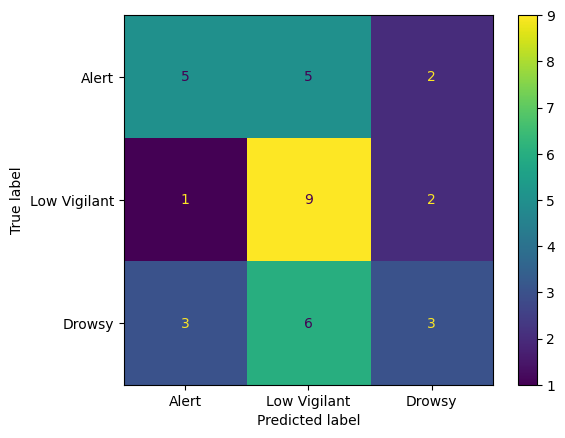

In [16]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

train_dataset = FeatureDataset(train_features, train_labels, train_lengths)
test_dataset = FeatureDataset(test_features, test_labels, test_lengths)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

model = GRUClassifier(input_dim=np.array(train_features[0]).shape[1], hidden_dim=128, num_classes=3, num_layers=2).to(device)
train_model(model, train_loader, test_loader, device,
                num_epochs=200, patience=10,
                checkpoint_path="/kaggle/working/best_model_4_test.pth")

## Third (fold 3 as test)

In [23]:
train_features, train_labels, train_lengths, test_features, test_labels, test_lengths = load_data(3, "frames")

Train 1/200: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Epoch 1: Train Loss 1.0970, Acc 0.3472 | Val Loss 1.1005, Acc 0.3889


Train 2/200: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


Epoch 2: Train Loss 1.0861, Acc 0.4306 | Val Loss 1.1001, Acc 0.3889


Train 3/200: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Epoch 3: Train Loss 1.0782, Acc 0.5000 | Val Loss 1.1015, Acc 0.4167


Train 4/200: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Epoch 4: Train Loss 1.0679, Acc 0.5139 | Val Loss 1.1019, Acc 0.3611


Train 5/200: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Epoch 5: Train Loss 1.0551, Acc 0.5694 | Val Loss 1.1036, Acc 0.3333


Train 6/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 6: Train Loss 1.0494, Acc 0.5278 | Val Loss 1.1072, Acc 0.2778


Train 7/200: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Epoch 7: Train Loss 1.0363, Acc 0.5833 | Val Loss 1.1103, Acc 0.3056


Train 8/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 8: Train Loss 1.0259, Acc 0.6042 | Val Loss 1.1147, Acc 0.3056


Train 9/200: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Epoch 9: Train Loss 1.0125, Acc 0.6042 | Val Loss 1.1190, Acc 0.2500


Train 10/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 10: Train Loss 0.9978, Acc 0.6111 | Val Loss 1.1236, Acc 0.3056


Train 11/200: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Epoch 11: Train Loss 0.9747, Acc 0.6250 | Val Loss 1.1296, Acc 0.3056


Train 12/200: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Epoch 12: Train Loss 0.9588, Acc 0.6389 | Val Loss 1.1408, Acc 0.3056
Early stopping triggered
Classification Report: 
               precision    recall  f1-score   support

       Alert       0.31      0.33      0.32        12
Low Vigilant       0.44      0.58      0.50        12
      Drowsy       0.43      0.25      0.32        12

    accuracy                           0.39        36
   macro avg       0.39      0.39      0.38        36
weighted avg       0.39      0.39      0.38        36



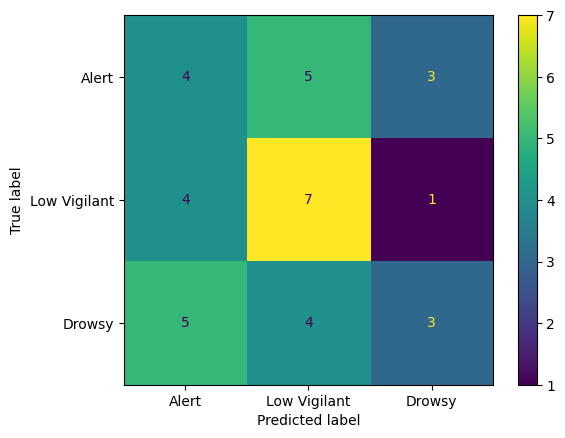

In [24]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

train_dataset = FeatureDataset(train_features, train_labels, train_lengths)
test_dataset = FeatureDataset(test_features, test_labels, test_lengths)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

model = GRUClassifier(input_dim=np.array(train_features[0]).shape[1], hidden_dim=128, num_classes=3, num_layers=2).to(device)
train_model(model, train_loader, test_loader, device,
                num_epochs=200, patience=10,
                checkpoint_path="/kaggle/working/best_model_3_test.pth")

## Fourth (fold 2 as test)

In [19]:
train_features, train_labels, train_lengths, test_features, test_labels, test_lengths = load_data(2, "frames")

Train 1/200: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


Epoch 1: Train Loss 1.1012, Acc 0.3056 | Val Loss 1.0998, Acc 0.3056


Train 2/200: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


Epoch 2: Train Loss 1.0869, Acc 0.3681 | Val Loss 1.0999, Acc 0.3056


Train 3/200: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Epoch 3: Train Loss 1.0820, Acc 0.4583 | Val Loss 1.0983, Acc 0.3611


Train 4/200: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Epoch 4: Train Loss 1.0791, Acc 0.4028 | Val Loss 1.0956, Acc 0.3333


Train 5/200: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


Epoch 5: Train Loss 1.0671, Acc 0.4931 | Val Loss 1.0925, Acc 0.3056


Train 6/200: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Epoch 6: Train Loss 1.0616, Acc 0.5278 | Val Loss 1.0899, Acc 0.3056


Train 7/200: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Epoch 7: Train Loss 1.0570, Acc 0.5833 | Val Loss 1.0875, Acc 0.3056


Train 8/200: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Epoch 8: Train Loss 1.0483, Acc 0.6111 | Val Loss 1.0834, Acc 0.3611


Train 9/200: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Epoch 9: Train Loss 1.0390, Acc 0.6111 | Val Loss 1.0797, Acc 0.3611


Train 10/200: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Epoch 10: Train Loss 1.0275, Acc 0.6181 | Val Loss 1.0748, Acc 0.3889


Train 11/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 11: Train Loss 1.0147, Acc 0.6597 | Val Loss 1.0709, Acc 0.4444


Train 12/200: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Epoch 12: Train Loss 1.0115, Acc 0.6944 | Val Loss 1.0671, Acc 0.4722


Train 13/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 13: Train Loss 0.9844, Acc 0.6806 | Val Loss 1.0626, Acc 0.4167


Train 14/200: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Epoch 14: Train Loss 0.9700, Acc 0.6597 | Val Loss 1.0616, Acc 0.4167


Train 15/200: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Epoch 15: Train Loss 0.9532, Acc 0.6875 | Val Loss 1.0606, Acc 0.4167


Train 16/200: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Epoch 16: Train Loss 0.9229, Acc 0.7292 | Val Loss 1.0420, Acc 0.4444


Train 17/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 17: Train Loss 0.9109, Acc 0.6875 | Val Loss 1.0360, Acc 0.4167


Train 18/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 18: Train Loss 0.8777, Acc 0.6944 | Val Loss 1.0352, Acc 0.4444


Train 19/200: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Epoch 19: Train Loss 0.8561, Acc 0.7014 | Val Loss 1.0313, Acc 0.4722


Train 20/200: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Epoch 20: Train Loss 0.8275, Acc 0.7361 | Val Loss 1.0306, Acc 0.5000


Train 21/200: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


Epoch 21: Train Loss 0.7811, Acc 0.7708 | Val Loss 1.0224, Acc 0.5000


Train 22/200: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


Epoch 22: Train Loss 0.7350, Acc 0.7917 | Val Loss 1.0281, Acc 0.4444


Train 23/200: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


Epoch 23: Train Loss 0.6970, Acc 0.8125 | Val Loss 1.0318, Acc 0.4722


Train 24/200: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Epoch 24: Train Loss 0.6618, Acc 0.8264 | Val Loss 1.0405, Acc 0.4722


Train 25/200: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Epoch 25: Train Loss 0.6293, Acc 0.8125 | Val Loss 1.0544, Acc 0.5000


Train 26/200: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Epoch 26: Train Loss 0.5651, Acc 0.8611 | Val Loss 1.0541, Acc 0.5000


Train 27/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 27: Train Loss 0.5358, Acc 0.8542 | Val Loss 1.0865, Acc 0.4722


Train 28/200: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Epoch 28: Train Loss 0.4999, Acc 0.8611 | Val Loss 1.1333, Acc 0.4722


Train 29/200: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Epoch 29: Train Loss 0.4599, Acc 0.8750 | Val Loss 1.1605, Acc 0.4722


Train 30/200: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 30: Train Loss 0.4200, Acc 0.8889 | Val Loss 1.2191, Acc 0.4444


Train 31/200: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Epoch 31: Train Loss 0.3708, Acc 0.8958 | Val Loss 1.2646, Acc 0.4167
Early stopping triggered
Classification Report: 
               precision    recall  f1-score   support

       Alert       0.47      0.58      0.52        12
Low Vigilant       0.64      0.75      0.69        12
      Drowsy       0.29      0.17      0.21        12

    accuracy                           0.50        36
   macro avg       0.47      0.50      0.47        36
weighted avg       0.47      0.50      0.47        36



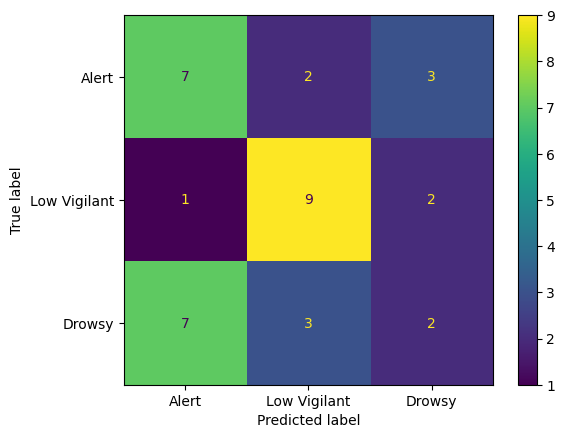

In [20]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

train_dataset = FeatureDataset(train_features, train_labels, train_lengths)
test_dataset = FeatureDataset(test_features, test_labels, test_lengths)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

model = GRUClassifier(input_dim=np.array(train_features[0]).shape[1], hidden_dim=128, num_classes=3, num_layers=2).to(device)
train_model(model, train_loader, test_loader, device,
                num_epochs=200, patience=10,
                checkpoint_path="/kaggle/working/best_model_2_test.pth")

## Fifth (fold 1 as test)

In [21]:
train_features, train_labels, train_lengths, test_features, test_labels, test_lengths = load_data(1, "frames")

Train 1/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 1: Train Loss 1.1003, Acc 0.3264 | Val Loss 1.0963, Acc 0.3889


Train 2/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 2: Train Loss 1.0913, Acc 0.3958 | Val Loss 1.0957, Acc 0.3889


Train 3/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 3: Train Loss 1.0845, Acc 0.4931 | Val Loss 1.0951, Acc 0.4167


Train 4/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 4: Train Loss 1.0832, Acc 0.4931 | Val Loss 1.0947, Acc 0.4444


Train 5/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 5: Train Loss 1.0769, Acc 0.5486 | Val Loss 1.0943, Acc 0.3889


Train 6/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 6: Train Loss 1.0720, Acc 0.5764 | Val Loss 1.0938, Acc 0.4167


Train 7/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 7: Train Loss 1.0625, Acc 0.6597 | Val Loss 1.0932, Acc 0.3889


Train 8/200: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Epoch 8: Train Loss 1.0596, Acc 0.5972 | Val Loss 1.0931, Acc 0.3889


Train 9/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 9: Train Loss 1.0503, Acc 0.6111 | Val Loss 1.0931, Acc 0.4444


Train 10/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 10: Train Loss 1.0448, Acc 0.6389 | Val Loss 1.0926, Acc 0.4444


Train 11/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 11: Train Loss 1.0357, Acc 0.7014 | Val Loss 1.0923, Acc 0.4444


Train 12/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 12: Train Loss 1.0232, Acc 0.7361 | Val Loss 1.0923, Acc 0.4444


Train 13/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 13: Train Loss 1.0128, Acc 0.7014 | Val Loss 1.0922, Acc 0.3889


Train 14/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 14: Train Loss 1.0034, Acc 0.6875 | Val Loss 1.0912, Acc 0.4167


Train 15/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 15: Train Loss 0.9827, Acc 0.7083 | Val Loss 1.0916, Acc 0.4167


Train 16/200: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 16: Train Loss 0.9728, Acc 0.7083 | Val Loss 1.0918, Acc 0.4167


Train 17/200: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 17: Train Loss 0.9580, Acc 0.7500 | Val Loss 1.0952, Acc 0.3889


Train 18/200: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 18: Train Loss 0.9372, Acc 0.7292 | Val Loss 1.0959, Acc 0.4167


Train 19/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 19: Train Loss 0.9126, Acc 0.7292 | Val Loss 1.0984, Acc 0.4167


Train 20/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 20: Train Loss 0.8976, Acc 0.7431 | Val Loss 1.1019, Acc 0.4167


Train 21/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 21: Train Loss 0.8704, Acc 0.7708 | Val Loss 1.1062, Acc 0.3889


Train 22/200: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 22: Train Loss 0.8432, Acc 0.7639 | Val Loss 1.1113, Acc 0.3889


Train 23/200: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 23: Train Loss 0.8089, Acc 0.7778 | Val Loss 1.1191, Acc 0.3333


Train 24/200: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 24: Train Loss 0.7870, Acc 0.7778 | Val Loss 1.1285, Acc 0.3611
Early stopping triggered
Classification Report: 
               precision    recall  f1-score   support

       Alert       0.41      0.58      0.48        12
Low Vigilant       0.50      0.58      0.54        12
      Drowsy       0.20      0.08      0.12        12

    accuracy                           0.42        36
   macro avg       0.37      0.42      0.38        36
weighted avg       0.37      0.42      0.38        36



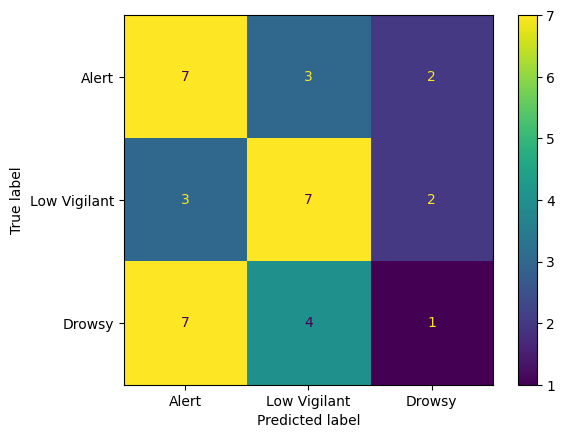

In [37]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

train_dataset = FeatureDataset(train_features, train_labels, train_lengths)
test_dataset = FeatureDataset(test_features, test_labels, test_lengths)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

model = GRUClassifier(input_dim=np.array(train_features[0]).shape[1], hidden_dim=128, num_classes=3, num_layers=2).to(device)
train_model(model, train_loader, test_loader, device,
                num_epochs=200, patience=10,
                checkpoint_path="/kaggle/working/best_model_1_test.pth")